In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
n1988 = pd.read_csv("~/Downloads/birth/NATL1988.txt")


In [ ]:
# https://www.cdc.gov/nchs/data_access/vitalstatsonline.htm 
# This notebook uses Nat1988.txt which is about 810 Mb.
# https://ftp.cdc.gov/pub/Health_Statistics/NCHS/Datasets/DVS/natality/Nat1988.zip 

# From the documentation of the detail natality file for 1990 data:
# NCHS has adopted a new policy on release of vital statistics unit record
# data files.  This new policy was implemented for the 1989 vital event
# files to prevent the inadvertent disclosure of individuals and institutions.
# As a result, the files for 1989 and later years do not contain the
# acutal day or the birth or the dates of birth of the mother or father.
# The geographic detail is also restricted...

In [9]:
n1988 = pd.read_csv("~/Downloads/birth/NATL1988.txt", header=None)

In [10]:
n1988.columns

Int64Index([0], dtype='int64')

Now I have a single column, creatively named "0"

In [139]:
n1988[0]

0          8010      110100299991771630100263211111231012...
1          8010      110100699990002630100663219223160304...
2          8010      110100699990002630100663212223241113...
3          8010      110100699990002630100663119223241113...
4          8010      110100699990002630100663219223261314...
                                 ...                        
3913788    8520      115101199990002835101183111111190607...
3913789    8520      115101199990002835101183119111200709...
3913790    8520      115101199990002835101183219111241113...
3913791    8520      115101599990002835101583111111291614...
3913792    8520      115102099990002835102083231111271414...
Name: 0, Length: 3913793, dtype: object

And you can see I have an index running from 0 to 3,913,792

This is a row.. How long is it?

It looks like I can access columns with square brackets and a column number.

In [ ]:
dir(pf.MATERNALAGE.value_counts())

In [ ]:
# So the first data parser I wrote is here. 
# It's slow, and I don't want to edit it every time
# a new column comes to my attention.

# Loop over the data, get columns 84-87 (month and date of birth)
# put it into a list, and finally put the list into a dataframe.
p = []
q = []
for i in n1988.index:
    p.append(n1988[0][i][(84-1):(85-1+1)]) # MONTH
    q.append(n1988[0][i][(86-1):(87-1+1)]) # DAY
birthdate = pd.DataFrame({"MONTH": p, "DAY":q})

Looking at the description...

![Data description](FIELDS.jpg "Exceprt from data description showing Date and month fields")

To get the data into our computing environment, we have three tasks:
1. extract columns (with the right field width)
2. associate columns with human-readable names 
3. decode symbols 

If we can put the layout of the database **into data, instead of code**, we can expand the scope of our investigation by modifying data, *not code*.  This will work well for us.

In [ ]:
# let's start with trying to use data to specify the layout,
# write a parser that generates a dataframe with column names,
# and we can expand to more columns (and decode the symbols) later.


In [13]:
# Let us start with something like these fields (which do not require decoding)
# This is a (pure python) list of lists
#  [ [startcolumn, stopcolumn, fieldname] ] 
dict1988 =[
    [84, 85, "MONTHOFBIRTH"],
    [86, 87, "DAYOFMONTH"],
]
# Since this is our data structure for our use, we can use any data type that works;
# there is no requirement that we use pandas or numpy here.


# Now, to organize my thoughts, I'm going to write a function prototype with a docstring that tells me what I need and what I promise to deliver.

In [ ]:
def parse_natality(natalitydata, datadictionary):
    '''Take in pandas dataframe natalitydata and list-of-lists 
    datadictionary  (for example [[43, 44, "MATERNALAGE"]] ) 
    and return a pandas dataframe (same number of rows) with 
    labeled columns  '''

In [ ]:
#  Where to start?  For loop over data dictionary first, or for loop over data?
#  Hint: which one is more expensive? This is the one we will want to do once.
# 

In [183]:
print(type(n1988[0]))
n1988[0]

<class 'pandas.core.series.Series'>


0          8010      110100299991771630100263211111231012...
1          8010      110100699990002630100663219223160304...
2          8010      110100699990002630100663212223241113...
3          8010      110100699990002630100663119223241113...
4          8010      110100699990002630100663219223261314...
                                 ...                        
3913788    8520      115101199990002835101183111111190607...
3913789    8520      115101199990002835101183119111200709...
3913790    8520      115101199990002835101183219111241113...
3913791    8520      115101599990002835101583111111291614...
3913792    8520      115102099990002835102083231111271414...
Name: 0, Length: 3913793, dtype: object

In [ ]:
# So I can access the cth column and ith row with df[0].loc[i][c]

In [189]:
# First I'm going to make certain I have the data I think I do
def parse_natality(natalitydata, datadictionary):
    '''Take in pandas dataframe natalitydata and list-of-lists datadictionary
    (for example [[43, 44, "MATERNALAGE"]] ) and return a pandas dataframe (same 
    number of rows) with labeled columns'''
    for index in natalitydata.index:
        for start, stop, column_name in datadictionary:
            if index < 3:
                print(index, start,stop, column_name)

In [190]:
parse_natality(n1988, dict1988)

0 84 85 MONTHOFBIRTH
0 86 87 DAYOFMONTH
1 84 85 MONTHOFBIRTH
1 86 87 DAYOFMONTH
2 84 85 MONTHOFBIRTH
2 86 87 DAYOFMONTH


In [191]:
# Above, we had hard-coded lists p and q that took all our intermediate data.  
# If we are going to automate column-extraction, we need a more flexible data structure.
# Dictionary of lists.
# So let's make a dictionary of empty lists first.
def parse_natality(natalitydata, datadictionary):
    '''Take in pandas dataframe natalitydata and list-of-lists datadictionary
    (for example [[43, 44, "MATERNALAGE"]] ) and return a pandas dataframe (same 
    number of rows) with labeled columns  '''
    intermediate_data={}
    # First, populate intermediate_data with empty lists for each column_name
    for start, stop, column_name in datadictionary:
        intermediate_data[column_name] = []
    # Now loop through the data    
    for index in natalitydata.index:
        for start, stop, column_name in datadictionary:
            if index < 3:
                print(index, start,stop, column_name)
    return intermediate_data

In [192]:
parse_natality(n1988, dict1988)

0 84 85 MONTHOFBIRTH
0 86 87 DAYOFMONTH
1 84 85 MONTHOFBIRTH
1 86 87 DAYOFMONTH
2 84 85 MONTHOFBIRTH
2 86 87 DAYOFMONTH


{'MONTHOFBIRTH': [], 'DAYOFMONTH': []}

In [193]:
def parse_natality(natalitydata, datadictionary):
    '''Take in pandas dataframe natalitydata and list-of-lists datadictionary
    (for example [[43, 44, "MATERNALAGE"]] ) and return a pandas dataframe (same 
    number of rows) with labeled columns  '''
    intermediate_data={}
    # First, populate intermediate_data with empty lists for each column_name
    for start, stop, column_name in datadictionary:
        intermediate_data[column_name] = []
    for idx in natalitydata.index:
        for start, stop, column_name in datadictionary:
            if idx < 3:
                datafield = natalitydata[0].loc[idx][start:(stop+1)]
                print(idx, start,stop, column_name, datafield)
    return intermediate_data

In [194]:
parse_natality(n1988, dict1988)

0 84 85 MONTHOFBIRTH 10
0 86 87 DAYOFMONTH 80
1 84 85 MONTHOFBIRTH 10
1 86 87 DAYOFMONTH 10
2 84 85 MONTHOFBIRTH 10
2 86 87 DAYOFMONTH 70


{'MONTHOFBIRTH': [], 'DAYOFMONTH': []}

In [195]:
# Well, that's not right.  Day of month 80?  Birth order 0?  Off-by-one again
def parse_natality(natalitydata, datadictionary):
    '''Take in pandas dataframe natalitydata and list-of-lists datadictionary
    (for example [[43, 44, "MATERNALAGE"]] ) and return a pandas dataframe (same 
    number of rows) with labeled columns  '''
    intermediate_data={}
    for start, stop, column_name in datadictionary:
        intermediate_data[column_name] = []
    for idx in natalitydata.index:
        for start, stop, column_name in datadictionary:
            if idx < 3:
                datafield = natalitydata.loc[idx][0][start-1:(stop-1+1)]
                print(idx, start,stop, column_name, datafield)
    return intermediate_data

In [196]:
parse_natality(n1988, dict1988)

0 84 85 MONTHOFBIRTH 01
0 86 87 DAYOFMONTH 08
1 84 85 MONTHOFBIRTH 01
1 86 87 DAYOFMONTH 01
2 84 85 MONTHOFBIRTH 01
2 86 87 DAYOFMONTH 07


{'MONTHOFBIRTH': [], 'DAYOFMONTH': []}

In [11]:
# These values look sane now, so let us put the data in lists.
def parse_natality(natalitydata, datadictionary):
    '''Take in pandas dataframe natalitydata and list-of-lists datadictionary
    (for example [[43, 44, "MATERNALAGE"]] ) and return a pandas dataframe (same 
    number of rows) with labeled columns  '''
    intermediate_data={}
    for start, stop, column_name in datadictionary:
        intermediate_data[column_name] = []
    for idx in natalitydata.index:
        for start, stop, column_name in datadictionary:
            datafield = natalitydata.loc[idx][0][start-1:(stop-1+1)]
            intermediate_data[column_name].append(datafield)
   #         if idx < 3:
   #              print(idx, start,stop, column_name, natalitydata.loc[idx][0][start-1:(stop-1+1)])
    return intermediate_data

In [14]:
parse_natality(n1988, dict1988)

KeyboardInterrupt: 

In [15]:
# Takes a while this time.  And it returns a hash of lists.  I'd prefer pandas data frames..
starttime = time.time()
parse_natality(n1988, dict1988)
stoptime = time.time()
print(stoptime-starttime)   # Agh.   12 minutes 

KeyboardInterrupt: 

In [16]:
# My code doesn't even give me a dataframe yet and it's taking forever.  
# Faster feedback will take me to my goal faster.. so create a dataframe 
# that only has 1% of the data: 
n1988sample = n1988[::100] # Not for production work
len(n1988sample)
n1988sample.head()

,0
0,8010 110100299991771630100263211111231012...
100,8010 110102399990002630102363211111210810...
200,8440 234302899990002620104263211111321915...
300,8010 110105799990661630105763219111231012...
400,8010 110101499990002630101463212223241113...


In [17]:
# transfer data from intermediate_data hash to pandas dataframe at the end
def parse_natality(natalitydata, datadictionary):
    '''Take in pandas dataframe natalitydata and list-of-lists datadictionary
    (for example [[43, 44, "MATERNALAGE"]] ) and return a pandas dataframe (same 
    number of rows) with labeled columns  '''
    intermediate_data={}
    for start, stop, column_name in datadictionary:
        intermediate_data[column_name] = []
    for idx in natalitydata.index:
        for start, stop, column_name in datadictionary:
            intermediate_data[column_name].append(natalitydata.loc[idx][0][start-1:(stop-1+1)])
   #         if idx < 3:
   #              print(idx, start,stop, column_name, natalitydata.loc[idx][0][start-1:(stop-1+1)])
    df = pd.DataFrame()
    for start, stop, column_name in datadictionary:
        print(column_name)
        df[column_name] = pd.Series(intermediate_data[column_name])
    return df

In [18]:
starttime=time.time()
df = parse_natality(n1988sample, dict1988)
stoptime=time.time()
print(stoptime-starttime)

MONTHOFBIRTH
DAYOFMONTH
7.164099216461182


In [19]:
# 7 seconds for 1/100 of the dataset
df

,MONTHOFBIRTH,DAYOFMONTH
0,01,08
1,01,07
2,01,04
3,01,02
4,01,03
...,...,...
39133,12,08
39134,12,06
39135,12,31
39136,11,01


In [ ]:
#  This puts my data in a reasonably good place, but now I worry about efficiency.
#  This didn't take long, but it was 1% of the whole dataset.
#  I only have to run this when I want to get new columns, but still, I want to 
#  lower my personal cost of accessing information.

# Why am I looping through all 4M records?  Because I am accessing 
# the columns by .loc[i][colnumber].  Can pandas help me?
# https://pandas.pydata.org/pandas-docs/version/1.3/user_guide/text.html 

# pd.str.get() will extract a single column *as a pandas dataframe*,
# so I can get all the rows with a single operation. 

In [204]:
# different approach:  .str.get() 
n1988sample[0].str.get(80)

0          1
100        1
200        1
300        1
400        1
          ..
3913300    1
3913400    1
3913500    1
3913600    1
3913700    1
Name: 0, Length: 39138, dtype: object

In [20]:
# Different approach
def parse_natality(natalitydata, datadictionary):
    '''Take in pandas dataframe natalitydata and list-of-lists datadictionary
    (for example [[43, 44, "MATERNALAGE"]] ) and return a pandas dataframe (same 
    number of rows) with labeled columns  '''
    df = pd.DataFrame()
    for start, stop, column_name in datadictionary:
        df[column_name] = natalitydata[0].str.get(start-1)
    return df


In [21]:
starttime=time.time()
df = parse_natality(n1988sample, dict1988) 
stoptime=time.time()
print(stoptime-starttime)

0.17567682266235352


In [22]:
df

,MONTHOFBIRTH,DAYOFMONTH
0,0,0
100,0,0
200,0,0
300,0,0
400,0,0
...,...,...
3913300,1,0
3913400,1,0
3913500,1,3
3913600,1,0


In [25]:
# almost there, but pd.str.get()  only gets one column at a time, and 
# MONTHOFBIRTH and DAYOFMONTH are two-column fields, that's why I'm 
# seeing month = 0

In [26]:
def parse_natality(natalitydata, datadictionary):
    '''Take in pandas dataframe natalitydata and list-of-lists datadictionary
    (for example [[43, 44, "MATERNALAGE"]] ) and return a pandas dataframe (same 
    number of rows) with labeled columns  '''
    df = pd.DataFrame()
    for start, stop, column_name in datadictionary:
        # Get the first column (start)
        df[column_name] = natalitydata[0].str.get(start-1)
        # Get the remaining columns
        for i in range(1, stop-start + 1):
            df[column_name]=  df[column_name].str.cat(natalitydata[0].str.get(start-1+i))
    return df

In [27]:
starttime=time.time()
df = parse_natality(n1988sample, dict1988) 
stoptime=time.time()
print(stoptime-starttime)
df.head()

0.2817819118499756


,MONTHOFBIRTH,DAYOFMONTH
0,01,08
100,01,07
200,01,04
300,01,02
400,01,03


In [28]:
# Looks reasonable.  We can expand to the entire dataset and
# make sure it completes in a reaosonable time:
starttime=time.time()
df = parse_natality(n1988, dict1988) 
stoptime=time.time()
print(stoptime-starttime)
df.head()

12.581115961074829


,MONTHOFBIRTH,DAYOFMONTH
0,01,08
1,01,01
2,01,07
3,01,06
4,01,01


In [29]:
type(df.MONTHOFBIRTH)

pandas.core.series.Series

In [30]:
# That doesn't answer my question
type(df.MONTHOFBIRTH[0])
# One more picky little request.. numeric data types?


str

In [31]:
def parse_natality(natalitydata, datadictionary):
    '''Take in pandas dataframe natalitydata and list-of-lists datadictionary
    (for example [[43, 44, "MATERNALAGE"]] ) and return a pandas dataframe (same 
    number of rows) with labeled columns  '''
    df = pd.DataFrame()
    for start, stop, column_name in datadictionary:
        # Get the first column (start)
        df[column_name] = natalitydata[0].str.get(start-1)
        # Get the remaining columns
        for i in range(1, stop-start + 1):
            df[column_name]=  df[column_name].str.cat(natalitydata[0].str.get(start-1+i))
    return df
    for start, stop, column_name in datadictionary:
        pd[column_name] = pd.to_numeric(pd[column_name])

In [32]:
df = parse_natality(n1988, dict1988) 
type(df.MONTHOFBIRTH[0])
df.head()

,MONTHOFBIRTH,DAYOFMONTH
0,01,08
1,01,01
2,01,07
3,01,06
4,01,01


In [33]:
# I am now satisfied that it is working.
dict1988 =[
    [84, 85, "MONTHOFBIRTH"],
    [86, 87, "DAYOFMONTH"],
    [60, 60, "BIRTHODRDER"],
    [41, 42, "MATERNALAGE"],
    [28, 29, "STATE"], 
    [69, 70, "PATERNALAGE"],
]

In [34]:
start = time.time()
df = parse_natality(n1988, dict1988) 
print(time.time() - start)

35.64549803733826


In [35]:
df

,MONTHOFBIRTH,DAYOFMONTH,BIRTHODRDER,MATERNALAGE,STATE,PATERNALAGE
0,01,08,2,23,01,22
1,01,01,1,16,01,99
2,01,07,3,24,01,26
3,01,06,1,24,01,99
4,01,01,4,26,01,99
...,...,...,...,...,...,...
3913788,06,28,2,19,51,20
3913789,07,11,1,20,51,99
3913790,12,18,4,24,51,99
3913791,12,20,6,29,51,30


In [36]:
age = df.MATERNALAGE.value_counts()

In [37]:
df.MATERNALAGE.value_counts().sort_index()

10        15
11        36
12       223
13      1804
14      8511
15     25611
16     55186
17     95932
18    133487
19    168485
20    185349
21    199385
22    212940
23    228896
24    241980
25    251485
26    255604
27    256243
28    245423
29    232004
30    212852
31    185984
32    160421
33    134290
34    110971
35     88625
36     68112
37     50907
38     36545
39     25657
40     17491
41     11305
42      5845
43      3121
44      1639
45       772
46       390
47       137
48        88
49        42
Name: MATERNALAGE, dtype: int64

In [38]:
age = df.MATERNALAGE.value_counts()

In [39]:
df.MATERNALAGE.value_counts().sort_index()

10        15
11        36
12       223
13      1804
14      8511
15     25611
16     55186
17     95932
18    133487
19    168485
20    185349
21    199385
22    212940
23    228896
24    241980
25    251485
26    255604
27    256243
28    245423
29    232004
30    212852
31    185984
32    160421
33    134290
34    110971
35     88625
36     68112
37     50907
38     36545
39     25657
40     17491
41     11305
42      5845
43      3121
44      1639
45       772
46       390
47       137
48        88
49        42
Name: MATERNALAGE, dtype: int64

<BarContainer object of 40 artists>

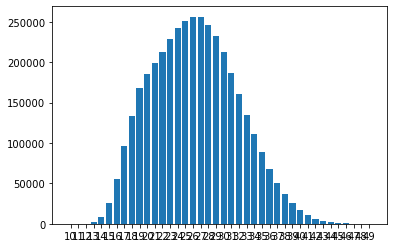

In [40]:
plt.bar(x=df.MATERNALAGE.value_counts().sort_index().index, height=df.MATERNALAGE.value_counts().sort_index().values)

<BarContainer object of 40 artists>

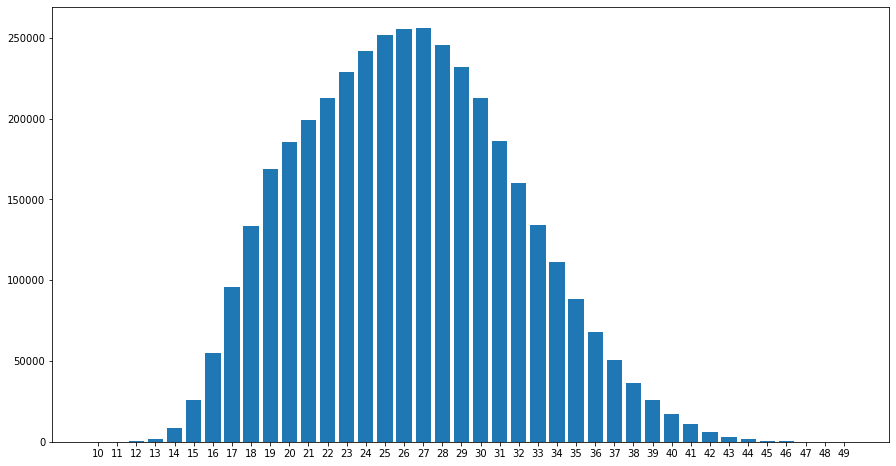

In [41]:
plt.figure(figsize=(15,8))
plt.bar(x=df.MATERNALAGE.value_counts().sort_index().index, height=df.MATERNALAGE.value_counts().sort_index().values)


(array([[3.30000e+02, 1.52000e+02, 1.80000e+01, 4.00000e+00, 1.00000e+00,
         0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.57300e+03],
        [3.00350e+04, 5.94940e+04, 2.66400e+03, 3.02000e+02, 4.90000e+01,
         1.20000e+01, 3.00000e+00, 2.00000e+00, 0.00000e+00, 9.26790e+04],
        [2.37280e+04, 4.04708e+05, 4.97680e+04, 4.98400e+03, 7.33000e+02,
         1.60000e+02, 4.70000e+01, 1.10000e+01, 0.00000e+00, 2.02567e+05],
        [1.71000e+03, 5.29612e+05, 2.42126e+05, 2.18470e+04, 2.77900e+03,
         5.56000e+02, 1.00000e+02, 1.80000e+01, 3.00000e+00, 1.36550e+05],
        [3.33000e+02, 2.35694e+05, 6.07801e+05, 5.78670e+04, 6.03700e+03,
         9.74000e+02, 1.55000e+02, 1.90000e+01, 2.00000e+00, 8.03920e+04],
        [1.11000e+02, 4.21460e+04, 4.92953e+05, 1.03438e+05, 9.32400e+03,
         1.37100e+03, 1.97000e+02, 2.30000e+01, 6.00000e+00, 4.39780e+04],
        [4.00000e+01, 1.04440e+04, 1.55220e+05, 1.20602e+05, 1.05510e+04,
         1.51600e+03, 2.69000e+0

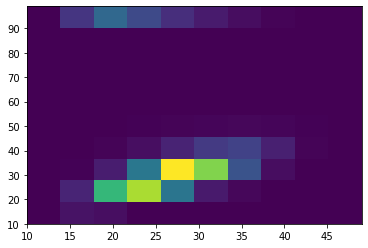

In [42]:
plt.hist2d(pd.to_numeric(df["MATERNALAGE"]), pd.to_numeric(df["PATERNALAGE"]))

(array([[0.00000e+00, 1.00000e+00, 1.00000e+00, 4.00000e+00, 5.00000e+00,
         0.00000e+00, 2.00000e+00, 3.00000e+00, 1.00000e+00, 2.00000e+00,
         0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
         0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
         0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
         0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 3.20000e+01],
        [1.00000e+00, 1.50000e+01, 1.60000e+01, 1.10000e+01, 2.00000e+00,
         3.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
         0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
         0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
         0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
         0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.75000e+02],
        [0.00000e+00, 6.80000e+01, 2.28000e+02, 8.90000e+01, 3.00000e+01,
         8.00000e+00, 6.00000e+00, 3

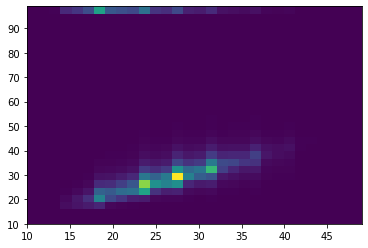

In [43]:
# More bins?
plt.hist2d(pd.to_numeric(df["MATERNALAGE"]), pd.to_numeric(df["PATERNALAGE"]), bins=30)

In [ ]:
And here we have an example of the hisogrammer's migrane.  
The field boundaries for both MATERNALAGE and PATERNALAGE
sometimes encompass different numbers of data points on the
underlying distribution over nonnegative integers.

We can always fix this by explicitly defining the bins to 
always include integer numbers of numbers.  

In [44]:
bins1 = np.arange(10,50) +.5
bins2 = np.arange(10,100)+.5

Text(0, 0.5, 'Paternal age')

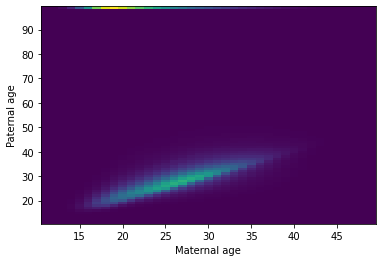

In [45]:
plt.hist2d(pd.to_numeric(df["MATERNALAGE"]), pd.to_numeric(df["PATERNALAGE"]), bins=(bins1, bins2))
plt.xlabel("Maternal age"); plt.ylabel("Paternal age")

Now we see something peculiar; the catch-all category 
PATERNALAGE=99 is a symbol for missing values.  
And just glancing at the heatmap shows the marginal
distribution of MATERNALAGE given PATERNALAGE=99 is 
peaked around 18.

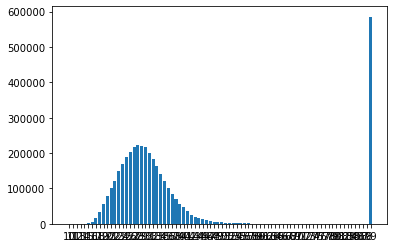

In [46]:
paternalage = df.PATERNALAGE.value_counts().sort_index()
plt.bar(paternalage.index, paternalage.values)
maternalage = df.MATERNALAGE.value_counts().sort_index()

<BarContainer object of 40 artists>

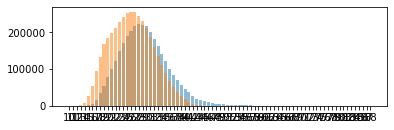

In [47]:
paternalage = df.PATERNALAGE.value_counts().sort_index()[:-1]

plt.subplot(211)
plt.bar(paternalage.index, paternalage.values, alpha=0.5)
plt.subplot(211)
plt.bar(maternalage.index, maternalage.values, alpha=0.5)



<BarContainer object of 40 artists>

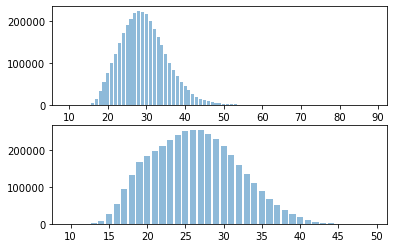

In [48]:

plt.subplot(211)
plt.bar(pd.to_numeric(paternalage.index), paternalage.values, alpha=0.5)
plt.subplot(212)
plt.bar(pd.to_numeric(maternalage.index), maternalage.values, alpha=0.5)


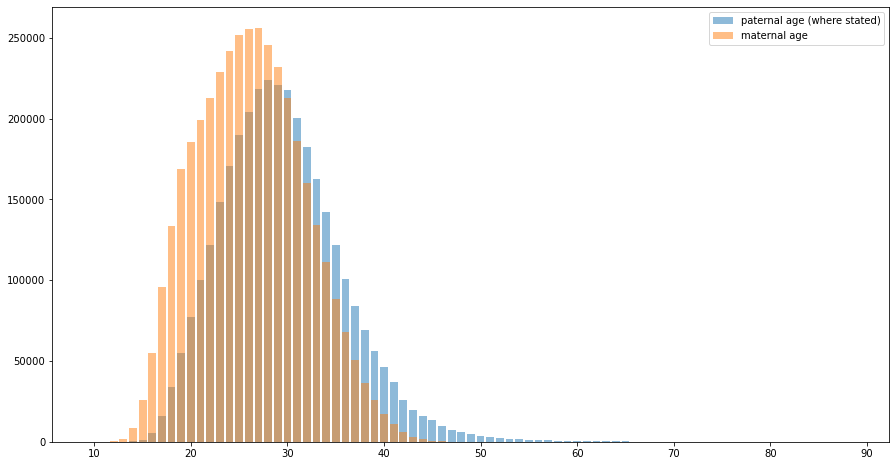

In [49]:
plt.figure(figsize=(15,8))
plt.bar(pd.to_numeric(paternalage.index), paternalage.values, alpha=0.5, label="paternal age (where stated)")
plt.bar(pd.to_numeric(maternalage.index), maternalage.values, alpha=0.5, label="maternal age")
plt.legend()

In [50]:
df["MATERNALAGE"]=pd.to_numeric(df.MATERNALAGE)

In [51]:
# Since I have a list of individual rows.. and I want something like a histogram.. I look
# into the pandas doucmentation for methods that aggregate dataframes:
# https://pandas.pydata.org/pandas-docs/stable/user_guide/groupby.html
#
gb = df.groupby(["MATERNALAGE", "STATE"])

In [52]:
gb.MATERNALAGE.median()

MATERNALAGE  STATE
10           05       10.0
             09       10.0
             10       10.0
             15       10.0
             18       10.0
                      ... 
49           24       49.0
             33       49.0
             39       49.0
             44       49.0
             50       49.0
Name: MATERNALAGE, Length: 1854, dtype: float64

In [53]:
# That doesn't look very usable..
gb = df.groupby(["STATE", "MATERNALAGE"])

In [54]:
gb.MATERNALAGE.count()

STATE  MATERNALAGE
01     12                8
       13               61
       14              221
       15              613
       16             1319
                      ... 
51     43                4
       44                4
       45                2
       46                2
       47                1
Name: MATERNALAGE, Length: 1854, dtype: int64

In [55]:
# Well, at least that's the 2d histogram that I can interpret..
gb.STATE.count()

STATE  MATERNALAGE
01     12                8
       13               61
       14              221
       15              613
       16             1319
                      ... 
51     43                4
       44                4
       45                2
       46                2
       47                1
Name: STATE, Length: 1854, dtype: int64

In [56]:
df.groupby("STATE")["MATERNALAGE"].median()

STATE
01    25.0
02    26.0
03    26.0
04    24.0
05    27.0
06    27.0
07    28.0
08    26.0
09    28.0
10    26.0
11    25.0
12    27.0
13    26.0
14    26.0
15    25.0
16    26.0
17    26.0
18    25.0
19    25.0
20    26.0
21    26.0
22    28.0
23    26.0
24    27.0
25    24.0
26    26.0
27    26.0
28    26.0
29    26.0
30    27.0
31    28.0
32    25.0
33    27.0
34    25.0
35    26.0
36    26.0
37    25.0
38    26.0
39    27.0
40    27.0
41    25.0
42    26.0
43    25.0
44    25.0
45    26.0
46    27.0
47    26.0
48    26.0
49    24.0
50    27.0
51    26.0
Name: MATERNALAGE, dtype: float64

In [ ]:
# That's it.  group by state, apply median() operator to MATERNALAGE field
# If only we could decode the states, we would see which states have on average older mothers.

* Fail early and often
* Invest in faster feedback
** Hack at, test code with subsets of the data
* Specify what you want before you do it
* Get it right first, make it fast later
* Usually better to use pandas/numpy than do it yourself

In [ ]:
# Cleaning up the numbers which are symbols is a little messier, but is possible:

In [59]:
h = {}
for line in open("STATE2829decoder.csv"):
    fields = line.strip().split()
    h[fields[0]] = fields[1]
h

{'01': 'AL',
 '02': 'AK',
 '03': 'AZ',
 '04': 'AR',
 '05': 'CA',
 '06': 'CO',
 '07': 'CT',
 '08': 'DE',
 '09': 'DC',
 '10': 'FL',
 '11': 'GA',
 '12': 'HI',
 '13': 'ID',
 '14': 'IL',
 '15': 'IN',
 '16': 'IA',
 '17': 'KS',
 '18': 'KY',
 '19': 'LA',
 '20': 'ME',
 '21': 'MD',
 '22': 'MA',
 '23': 'MI',
 '24': 'MN',
 '25': 'MS',
 '26': 'MO',
 '27': 'MT',
 '28': 'NE',
 '29': 'NV',
 '30': 'NH',
 '31': 'NJ',
 '32': 'NM',
 '33': 'NY',
 '34': 'NC',
 '35': 'ND',
 '36': 'OH',
 '37': 'OK',
 '38': 'OR',
 '39': 'PA',
 '40': 'RI',
 '41': 'SC',
 '42': 'SD',
 '43': 'TN',
 '44': 'TX',
 '45': 'UT',
 '46': 'VT',
 '47': 'VA',
 '48': 'WA',
 '49': 'WV',
 '50': 'WI',
 '51': 'WY',
 '52': 'PR',
 '53': 'VI',
 '54': 'GU',
 '55': 'CA',
 '56': 'CU',
 '57': 'MX',
 '59': 'XX'}

In [62]:
df["STATEA"] = df.STATE.apply(lambda x: h[x])

In [68]:
df.groupby([ "STATEA"]).MATERNALAGE.median().sort_values()

STATEA
MS    24.0
AR    24.0
WV    24.0
NC    25.0
TX    25.0
TN    25.0
SC    25.0
GA    25.0
LA    25.0
OK    25.0
AL    25.0
KY    25.0
IN    25.0
NM    25.0
WA    26.0
ND    26.0
NE    26.0
OH    26.0
MT    26.0
SD    26.0
UT    26.0
VA    26.0
NV    26.0
OR    26.0
AK    26.0
WY    26.0
MI    26.0
ME    26.0
MD    26.0
AZ    26.0
KS    26.0
IL    26.0
ID    26.0
IA    26.0
MO    26.0
DE    26.0
FL    26.0
WI    27.0
VT    27.0
CA    27.0
CO    27.0
MN    27.0
PA    27.0
NY    27.0
NH    27.0
RI    27.0
HI    27.0
DC    28.0
CT    28.0
NJ    28.0
MA    28.0
Name: MATERNALAGE, dtype: float64

In [69]:
# Funny.  All of these are integers.  